<a href="https://colab.research.google.com/github/dillanhoyos/Cl/blob/main/09_skimlit_nlp_milestone_project_2_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLlit
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier. 
The paper were replicating(the source of the dataset that well be using is available here: https://arxiv.org/pdf/1710.06071.pdf)\

And reading through the paper above we see that the model architure that they use to achieve their best reuslt si is available herE: 

*Resource* if you wat to find the ground truth for this note book(with lots of diagrams and text anothations see the Github)

Confirm acces toGPU

In [ ]:
!nvidia-smi

Sat Jun 10 21:57:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Get data 
Since well be replicating the paper above (pubmed 200k RCT)

We can do so from the authors Github: 


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.46 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#Check what file sare in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


dev.txt  test.txt  train.txt


In [ ]:
#Start our experiments using the 20k dataset with numbers replaceed by "@" sign 
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
data_dir



'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
#Chek all of the filenames in the target directory 
import os 
filenames= [ data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Preprocess data
Now we've got some text data, its time to become on with it . 
And one of the best ways to become one with tdata is to..... 

> VIsualize, Visualize, Visualize 

So with that in mind, lets write a function to read inall of the line sof a target text file. 

In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Read filename (a text filename ) and return the lines of text as a list. 

  Args:
    filanme: a string containing the target filepath. 

  Returns: 
    A list of string with one string per line form the target filename.
  """

  with open(filename, "r") as f: 
    return f.readlines()
    
  

In [ ]:
# Lets read in the trining lines 
train_lines = get_lines(data_dir+"train.txt")
train_lines[:3]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n']

In [ ]:
len(train_lines)

210040

Lets think about how we want our data to look 

How I think our data would be best represented ....
```
[{'line_number`: 0,
  `target`: Background,
  `text`: Emotional eating is associated with overeating and the development of obesity,
  `total_lines: 11}]

  ```

In [ ]:

for i, lines in enumerate(train_lines[:10]):

  Target = lines.split()[0]
  Text = lines

  # Text = lines.join(Target[1:])
  print(f"LineNumber{i}")
  print(f"Target: {Target}")
  print(f"Text {Text}")


  

LineNumber0
Target: ###24293578
Text ###24293578

LineNumber1
Target: OBJECTIVE
Text OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

LineNumber2
Target: METHODS
Text METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

LineNumber3
Target: METHODS
Text METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

LineNumber4
Target: METHODS
Text METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .

LineNumber5
Target: METHODS
Text METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment (

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionarie sof abstract line data. 

  Takes in filename, read it contents and sort through each line, 
  extracting things like the target labels, the text of the sentences
  how many sentences are in the current abstract and what sentence number the target line is. 
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract 
  abstract_samples = [] # create an empy list of abstract

  #loop through each line in the target file 
  for line in input_lines:
    if line.startswith("###"): #Check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the lines is an ID line
    elif line.isspace(): #Check to see if line is a new line 
      abstract_line_split = abstract_lines.splitlines()#split abstract into separate lines

      #Iterate through each line ina single abstract and count htem at the same time 
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #Create an empty dictionary for each line 
        target_text_split = abstract_line.split("\t") #split target label for text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it 
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 #How many total lines are the in the target abstract?(start)

        abstract_samples.append(line_data) #add line data to abstract samples list

    else:# if the above conditions arent fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
#Get data from file and preprocess it 
%%time 
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir +"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir +"test.txt")

len(train_samples), len(val_samples), len(test_samples)


CPU times: user 604 ms, sys: 95.6 ms, total: 699 ms
Wall time: 769 ms


(180040, 30212, 30135)

In [ ]:
#Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we tuen it into a Dataframe to further visualize it.

In [ ]:
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

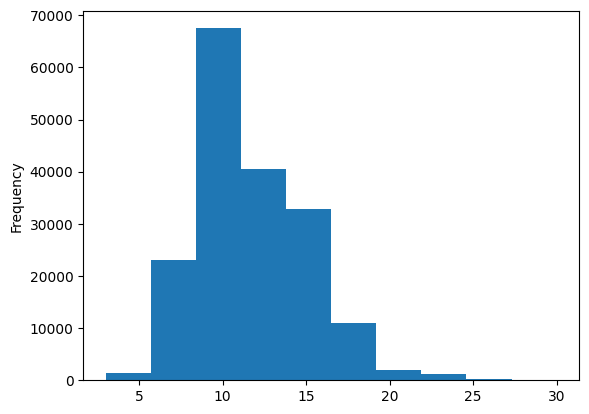

In [ ]:
#Lets check the length of differnet lines 
train_df.total_lines.plot.hist()

### Get list of sentences 


In [ ]:
#Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [ ]:
#VIew the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numberic labels (ML Models require numeric labels)

In [ ]:
# One hot encode labels 
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) #we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


#Check what one hot encoded labels look like 
train_labels_one_hot
val_labels_one_hot
test_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

Label encode labels"


In [ ]:
#Extract Labels ("target columns") and encode the into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#Check what training labels look like 
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
#Get class names and number of classes form labelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modellin experiments.. 

As usual, were going to be trying out a bunch of different models and seeing which one works best. 
And as always, were going to start with a baseline(TF-IDF Multinomial Naive Bayes classifier)


In [ ]:
## Model 0: Getting a baseline

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

#Create a pipeline 
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fit the pipeline to the traiing data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)



Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate baseline model on validation dataset 
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
#Make predictions using our baseline model 
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script 

In the previous modeule, we wrote a function to compare predictions across different metrics(accuracy, precision, recal and f1) and rather than rewriting it here, lets download it here 
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-10 21:58:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-10 21:58:10 (82.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results 
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Preparing our text to be in text tokens and then embeddings for deep sequence model 

Before we start building deeper models, weve go to create vectorization and embdedding layers


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers 


In [ ]:
#How long is each sentence on averagese
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [ ]:
#How long is each sentence on average? 
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

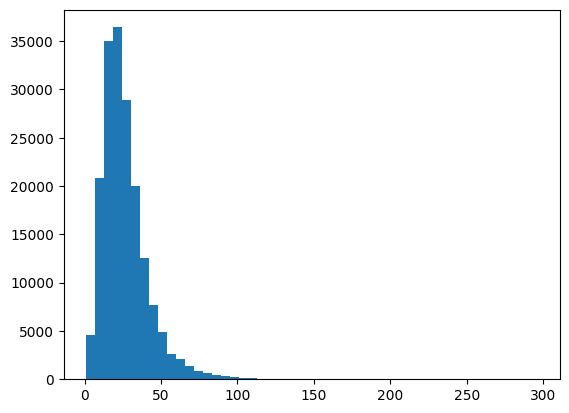

In [ ]:
# whats the distribution look like?

import matplotlib.pyplot as plt 
plt.hist(sent_lens, bins=50);

In [ ]:
# How long of a sentences length covers95% of examples? 
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
#Maximmum sequence length in the training set 
max(sent_lens)

296

### Create text vecotrizer layer 
We want to make a layer which turns our texts from words to numbers. 


In [ ]:
#How many words ar ein our vocab? (taken from table 2 in )

max_tokens=68000


In [ ]:
#Create text Vectorizer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Number of vocabulary
                                    output_sequence_length=output_seq_len) #desired output lenght of vectorization

                                    


In [ ]:
#Adapt text vectoizer to training sentences 
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorizer on random sentences 
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: { len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
tccs built after @d alignments show the best indices as well as producing the most reliable maps .

Length of text: 98

Vectorized text: [[21600  7401    21   187 41287   812     2   946  1555    25   221    25
   5256     2   215  2006  5495     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary rc
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most Common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least commons words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab:64841
Most Common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least commons words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer 
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding 

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different number of parameters to train 
                               mask_zero=True, #use masking to handle variable sequence lengths(Save space),
                               name="token_embedding") 

In [ ]:
#Show example embedding 
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 tccs built after @d alignments show the best indices as well as producing the most reliable maps .

Sentence after vectorization (before embedding):
 [[21600  7401    21   187 41287   812     2   946  1555    25   221    25
   5256     2   215  2006  5495     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.02668737 -0.02367815 -0.0001726  ... -0.00378395  0.00201327
    0.0292171 ]
  [-0.03083605 -0.00406319 -0.03445574 ...  0.02436146  0.02191441
   -0.01937997]
  [-0.04686768 -0.03664958  0.0278422  ... -0.04625402  0.01548285
    0.02919649]
  ...
  [-0.02280673 -0.04156739 -0.04207838 ... -0.02335153 -0.01674644
   -0.04040784]
  [-0.02280673 -0.04156739 -0.04207838 ... -0.02335153 -0.01674644
   -0.04040784]
  [-0.02280673 -0.04156739 

## Creating datasets(making sure our data loads as fast as posible)

We're going to setup our data to run as fast asp posible with the TensorFlow Tf.Data API 


In [ ]:
#Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorsliceDatasets and turn them into prefetched datasets 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Model 1 Conv1D with token embeddings 


In [ ]:
#Create 1D conv model to process sequences 
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs 
token_embeddings = token_embed(text_vectors) #Cerate embedding 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile 
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
train_dataset, len(train_dataset)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 5627)

In [ ]:
# Fit the model 
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)), # only validate on 19% of batches
                              )

Epoch 1/3
562/562 [==============================] - 46s 64ms/step - loss: 0.9184 - accuracy: 0.6345 - val_loss: 0.6882 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6557 - accuracy: 0.7571 - val_loss: 0.6317 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6162 - accuracy: 0.7744 - val_loss: 0.5950 - val_accuracy: 0.7866


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5959 - accuracy: 0.7876


[0.595860481262207, 0.7876340746879578]

In [ ]:
#Make predicitons(our model predicts prediction probabiliities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.4030643e-01, 1.7136301e-01, 6.9230914e-02, 2.9398620e-01,
         2.5113445e-02],
        [4.7159907e-01, 2.5878271e-01, 1.2148516e-02, 2.4967241e-01,
         7.7971849e-03],
        [1.5494040e-01, 5.9292777e-03, 1.6961700e-03, 8.3739680e-01,
         3.7424987e-05],
        ...,
        [5.6969693e-06, 6.5313035e-04, 6.4470747e-04, 3.3864733e-06,
         9.9869305e-01],
        [4.5536727e-02, 4.7382841e-01, 7.9670772e-02, 5.7277646e-02,
         3.4368649e-01],
        [1.8760781e-01, 6.9010693e-01, 4.1192655e-02, 5.2357320e-02,
         2.8735347e-02]], dtype=float32),
 (30212, 5))

In [ ]:
#Convert pred probs to classes 
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
#calculate model_1_results 
model_1_results = calculate_results(y_true=val_labels_encoded, 
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.76340526942937,
 'precision': 0.78446648334019,
 'recall': 0.7876340526942937,
 'f1': 0.7852993552752201}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
!wget https://tfhub.dev/google/universal-sentence-encoder/4

--2023-06-10 21:59:32--  https://tfhub.dev/google/universal-sentence-encoder/4
Resolving tfhub.dev (tfhub.dev)... 74.125.20.113, 74.125.20.100, 74.125.20.102, ...
Connecting to tfhub.dev (tfhub.dev)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘4’

4                       [ <=>                ]   1.21K  --.-KB/s    in 0s      

2023-06-10 21:59:33 (20.3 MB/s) - ‘4’ saved [1237]



# Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from tensorflow hub, more specifically the USE 

The paper originally used GLove embeddings, however, werer going to stick with USE 


In [ ]:
#Download pretrained Tensorflow hub USE 
import tensorflow_hub as hub 
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal-sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][30]}\n")
print(f"Lenght of sentence embedding:{len(use_embedded_sentence[0])}")


Sentence:
an independent blinded observer graded the scar halves with the vancouver scar scale ( vss ) immediately prior to treatment and @ weeks after treatment .
Sentence after embedding:
-0.0740777924656868

Lenght of sentence embedding:512


In [ ]:
##Building fitting an NLP feature extractio model using pretrained ebedding s form TF ub
#Dfine feature extraction model using TF Hub layer 
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence(512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)

# Note: you could add more layers here if you wante to 
outputs = layers.Dense(num_classes, activation="softmax")(x) #create the output layer
model_2 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs,
                         name="model_2_use_feature_extractor")

#Compile th model 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal-sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
#Fit the model_2 to the data 
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 17ms/step - loss: 0.9150 - accuracy: 0.6507 - val_loss: 0.7979 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7688 - accuracy: 0.7012 - val_loss: 0.7550 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7519 - accuracy: 0.7109 - val_loss: 0.7398 - val_accuracy: 0.7094


In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)


945/945 [==============================] - 9s 10ms/step


In [ ]:
model_2_pred_probs

array([[0.41661546, 0.3875119 , 0.00183444, 0.18551882, 0.00851933],
       [0.34386283, 0.4989321 , 0.00279709, 0.15191925, 0.00248878],
       [0.2569589 , 0.11895675, 0.01470327, 0.5699037 , 0.03947745],
       ...,
       [0.00168549, 0.00556049, 0.05703744, 0.00101064, 0.9347059 ],
       [0.00385188, 0.04382104, 0.17722124, 0.00160288, 0.77350295],
       [0.19563608, 0.2829938 , 0.4503521 , 0.00859731, 0.06242065]],
      dtype=float32)

In [ ]:
#Conver the prediction probabilities found with feature extraction model to lable 
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#Calculate results from TF Hub pretrained embeddings 

model_2_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_2_preds)

model_2_results

{'accuracy': 71.37230239639878,
 'precision': 0.7139687839216904,
 'recall': 0.7137230239639878,
 'f1': 0.7105823151502598}

In [ ]:
model_1_results

{'accuracy': 78.76340526942937,
 'precision': 0.78446648334019,
 'recall': 0.7876340526942937,
 'f1': 0.7852993552752201}

## Model 3: Conv1D with hcharacter embeddings 
The paper which were replicating states they used a combination of token and character-level embeddings . 
Previsously weve token-level embeddings but well need to similar steps for characters if we want to use char-level embedings. 


### Creating a character=level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
#Make function to split sentences into characters 
def split_chars(text):
  return " ".join(list(text))



In [ ]:
#Test splitting non-character level sequence into characters 
split_chars(random_train_sentence)

'a n   i n d e p e n d e n t   b l i n d e d   o b s e r v e r   g r a d e d   t h e   s c a r   h a l v e s   w i t h   t h e   v a n c o u v e r   s c a r   s c a l e   (   v s s   )   i m m e d i a t e l y   p r i o r   t o   t r e a t m e n t   a n d   @   w e e k s   a f t e r   t r e a t m e n t   .'

In [ ]:
#Split sequence-level data splits into character-level data splits 
train_chars =[split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#Whats the average character lenght ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len


149.3662574983337

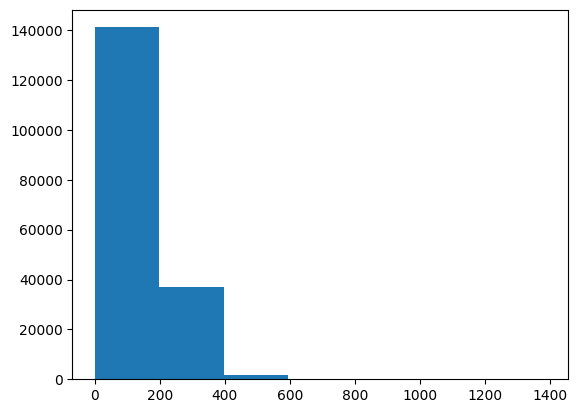

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(char_lens, bins=7);

In [ ]:
#Find what character length cover 95% of seqyences 
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
random.choice(train_sentences)


'dmard treatment dose escalation and therapy changes will be measured to evaluate the primary objective .'

In [ ]:
#Get all keyboard character 
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 #add 2 for space and OOV token(OOV - out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="Char_vectorizer")

In [ ]:
#Adapt cahracte vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different character in character vocab{len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 leas common characters:{char_vocab[-5]}")

Number of different character in character vocab28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 leas common characters:k


In [ ]:
#Test out characte vectorizer 
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: { len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: { len(vectorized_chars)}")

Charified text:
 w e   a s s e s s e d   t h e   e f f e c t s   o f   p r o g r e s s i v e   r e s i s t a n c e   t r a i n i n g   (   p r t   )   c o m b i n e d   w i t h   a   p r o t e i n - e n r i c h e d   d i e t   f a c i l i t a t e d   t h r o u g h   l e a n   r e d   m e a t   o n   l e a n   t i s s u e   m a s s   (   l t m   )   ,   m u s c l e   s i z e   ,   s t r e n g t h   a n d   f u n c t i o n   ,   c i r c u l a t i n g   i n f l a m m a t o r y   m a r k e r s   ,   b l o o d   p r e s s u r e   ,   a n d   l i p i d s   i n   e l d e r l y   w o m e n   .
Length of random_train_chars: 575
\Vectorized chars:
 [[20  2  5  9  9  2  9  9  2 10  3 13  2  2 17 17  2 11  3  9  7 17 14  8
   7 18  8  2  9  9  4 21  2  8  2  9  4  9  3  5  6 11  2  3  8  5  4  6
   4  6 18 14  8  3 11  7 15 22  4  6  2 10 20  4  3 13  5 14  8  7  3  2
   4  6  2  6  8  4 11 13  2 10 10  4  2  3 17  5 11  4 12  4  3  5  3  2
  10  3 13  8  7 16 18 13 12  2  5  6  8  2 10 15  2  5  

## Creating a character-level embedding

In [ ]:
#Create char embedding layer 
char_embed = layers.Embedding(input_dim=len(char_vocab),# number of different characters)
                              output_dim=25, # This is the ise of the char embedding in the paper 
                              mask_zero=True,
                              name="char_embed")



In [ ]:
# Test our character embedding layer 
print(f"Charfied text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embed chars for vectorization and embedding: \n{char_embed_example}\n")
print(f"Character embedding shape: { char_embed_example.shape}")

Charfied text:
 w e   a s s e s s e d   t h e   e f f e c t s   o f   p r o g r e s s i v e   r e s i s t a n c e   t r a i n i n g   (   p r t   )   c o m b i n e d   w i t h   a   p r o t e i n - e n r i c h e d   d i e t   f a c i l i t a t e d   t h r o u g h   l e a n   r e d   m e a t   o n   l e a n   t i s s u e   m a s s   (   l t m   )   ,   m u s c l e   s i z e   ,   s t r e n g t h   a n d   f u n c t i o n   ,   c i r c u l a t i n g   i n f l a m m a t o r y   m a r k e r s   ,   b l o o d   p r e s s u r e   ,   a n d   l i p i d s   i n   e l d e r l y   w o m e n   .

Embed chars for vectorization and embedding: 
[[[-3.0097652e-02  1.6747776e-02 -3.1539716e-02 ...  1.8138472e-02
    2.2318546e-02 -1.8692769e-02]
  [ 1.6586557e-03  3.7296679e-02 -1.7817222e-02 ... -4.7466755e-03
    4.3324780e-02 -2.0415187e-03]
  [ 1.4133643e-02  3.4085419e-02  2.5711540e-02 ... -4.7121227e-02
    2.5204543e-02 -8.6867921e-03]
  ...
  [-4.7752131e-02  3.0747022e-02 -2.1062374e-02 ... 

In [ ]:
len(random_train_chars)

575

### building Conv1D layer for our model 


In [ ]:
#Make Conv1D on chars only 
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs,
                         name="model_3_conv1D_char_embeddings")


#Compile 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# Summary 
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 Char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 

In [ ]:
# Create char level datasets 
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#Fit the model on chars only 
model_3_history = model_3.fit(train_char_dataset, 
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2581 - accuracy: 0.4823 - val_loss: 1.1230 - val_accuracy: 0.5492
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0793 - accuracy: 0.5588 - val_loss: 1.0008 - val_accuracy: 0.5981
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9872 - accuracy: 0.6058 - val_loss: 0.9326 - val_accuracy: 0.6297


In [ ]:
#Make predicitons with character model only 
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[0.159337  , 0.32554123, 0.11522408, 0.35693592, 0.04296175],
       [0.2254919 , 0.42994493, 0.00767329, 0.32690617, 0.00998363],
       [0.10183196, 0.1812669 , 0.16214225, 0.52523214, 0.02952674],
       ...,
       [0.02065676, 0.05326834, 0.23403178, 0.01880381, 0.67323935],
       [0.04498944, 0.14875868, 0.39780256, 0.09710812, 0.31134123],
       [0.46364978, 0.32479003, 0.09439589, 0.10792856, 0.00923579]],
      dtype=float32)

In [ ]:
#Convert prediciton probabilities to class labels 
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 0])>

In [ ]:
#Calculate results for Conv1D model chars only 
model_3_results = calculate_results(y_true=val_labels_encoded, 
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 62.8657487091222,
 'precision': 0.6337714764405994,
 'recall': 0.628657487091222,
 'f1': 0.6173609876387371}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embeddings model)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model(similar to `model_3` with a slight modificiation )
3. Combine 1&2 with a concatenate(`layers.Concatenat`)
4. Build a series of output laers on top of 3 similar to figure 1 and section 4.2. 
5. Construct a model which takes token and character-level sequences as input and produces sequences label probabilities as output 


In [ ]:
# 1. Setup token inputs/model 
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)


#2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)# bi_LSTM shown in Figure 1 of the paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)



#3. Concatenate token and char inputs(create hybrid token embedding )

token_char_concat = layers.Concatenate(name="token-char_hybrid")([token_model.output,
                                                                  char_model.output])


#4. Create output layers - adding in dropout, discussed in section 4.2 of the paper 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Contruct model with char and token inputs 
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
# Get a summary of our model 
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 Char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal-sentence_encoder (Ke  (None, 512)         256797824   [

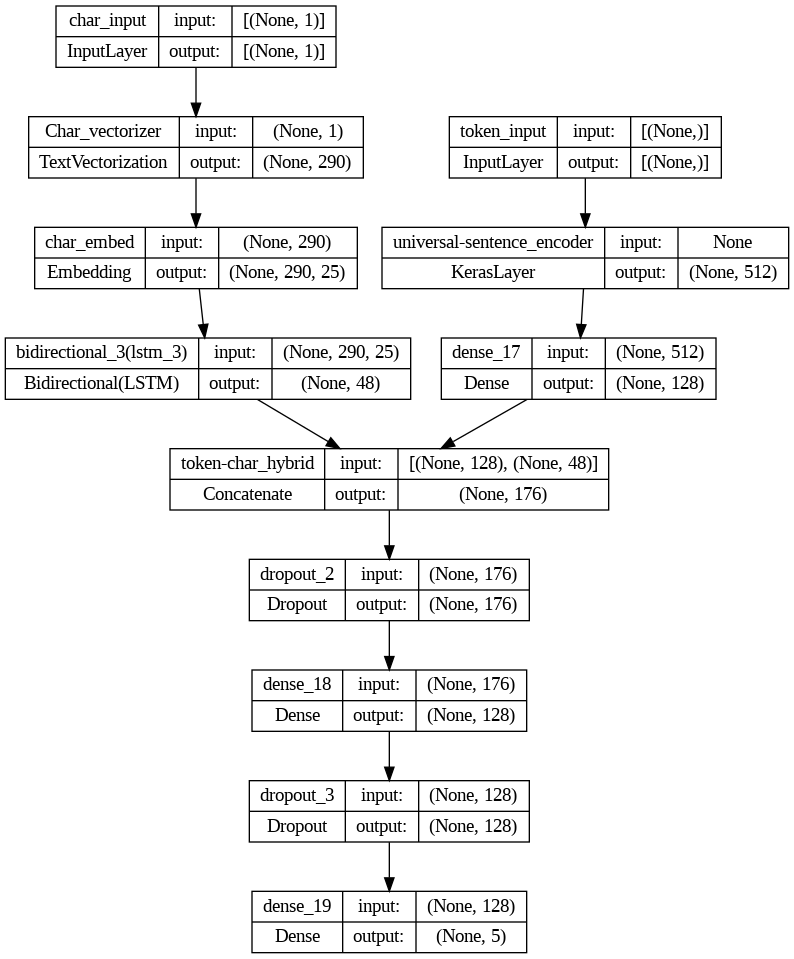

In [ ]:
#Plot hybrid token and character model 
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model 
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),#section 4.2 of the paper says they use SGD, you might to try this 
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
#Combine chars and tokens into a dataset 
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)#make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data anad labels 

#prefetch and batch train data 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# repeat the above steps for our validation data 
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)#make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data anad labels 

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Check out out training char and token embedding dataset 
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences


In [ ]:
# Fit the model on token and chars
history_model_4 = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 56ms/step - loss: 0.9838 - accuracy: 0.6068 - val_loss: 0.7756 - val_accuracy: 0.7078
Epoch 2/3
562/562 [==============================] - 31s 55ms/step - loss: 0.8008 - accuracy: 0.6901 - val_loss: 0.7198 - val_accuracy: 0.7217
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7737 - accuracy: 0.7025 - val_loss: 0.6994 - val_accuracy: 0.7374


In [ ]:
#Evaluate on the whole validaion dataset 
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 32s 34ms/step - loss: 0.7048 - accuracy: 0.7310


[0.7047756314277649, 0.7310340404510498]

In [ ]:
#Make predicitons using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)


945/945 [==============================] - 24s 22ms/step


In [ ]:
model_4_pred_probs

array([[4.5820740e-01, 3.1238413e-01, 3.7794556e-03, 2.2136733e-01,
        4.2616939e-03],
       [3.6691359e-01, 4.7382757e-01, 3.1069568e-03, 1.5450223e-01,
        1.6496344e-03],
       [3.0845875e-01, 1.3934888e-01, 4.6733554e-02, 4.7567821e-01,
        2.9780682e-02],
       ...,
       [1.0321488e-03, 1.0087278e-02, 4.3710168e-02, 4.0027226e-04,
        9.4477010e-01],
       [5.9076231e-03, 5.7660915e-02, 2.2271535e-01, 3.6337804e-03,
        7.1008235e-01],
       [4.1748443e-01, 3.2747236e-01, 1.7930169e-01, 2.5845243e-02,
        4.9896188e-02]], dtype=float32)

In [ ]:
#Format pred probs into pred labels 
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [ ]:
model_4_results

{'accuracy': 73.10340262147491,
 'precision': 0.7330309855469351,
 'recall': 0.7310340262147491,
 'f1': 0.7295252312890925}

## Model 5: Transfer learning with pretrained token ebeddings + character embeddings + positional embeddings 

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
